In [2]:
import pandas as pd
import numpy as np
import os
from scipy.io import wavfile
import torchaudio
from defs import *
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import timm
import librosa

In [3]:
from featurizers.linear import LinearFeaturizer
from featurizers.spectogram import MelFeaturizer
from models.linear import LinearNet
from models.cnn import CNN
from models.ast import ASTModel
from dataset import SimpleDataset
from pl_module import PlModule

In [4]:
df = pd.read_csv('data/ESC-50-master/meta/esc50.csv')

In [17]:
srs = []
lens = []
for i in df.filename:
    wav, sr = torchaudio.load(os.path.join(AUDIO_PATH, i))
    srs.append(sr)
    lens.append(wav.shape[1])


In [23]:
sr

44100

In [4]:
N_MELS = 64
N_LINEAR_FEATURES = 8

dataset = SimpleDataset(df, AUDIO_PATH)
dataloader = DataLoader(dataset, batch_size=64)
spectogram_featurizer = MelFeaturizer(n_mels=N_MELS)
linear_featurizer = LinearFeaturizer(spectogram_featurizer)
model = ASTModel(50, input_fdim=224, input_tdim=224, model_size="tiny224")
pl_module = PlModule(model, linear_featurizer, 0.001)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=441


In [8]:
audios, targets = next(iter(dataloader))

In [9]:
features = spectogram_featurizer(audios)


In [10]:
features.shape

torch.Size([64, 1, 64, 862])

In [7]:
model(features)

tensor([[-0.5205,  0.7333,  0.4740,  ...,  0.4224, -0.0982, -0.2405],
        [-0.8012,  1.1318,  0.1303,  ..., -1.2673,  0.3258,  0.1102],
        [-0.4475,  0.4655,  0.7175,  ..., -1.4979,  0.4783, -0.5718],
        ...,
        [-0.6733,  1.9280,  0.2375,  ..., -0.6422, -0.1121, -0.7920],
        [-0.7778,  0.5833, -0.1581,  ..., -0.0924,  0.0949,  0.7409],
        [-0.0527,  1.5197,  0.7101,  ..., -0.5646,  0.4826, -0.4979]],
       grad_fn=<AddmmBackward0>)

In [19]:
features = spectogram_featurizer(audios)
features = torch.nn.functional.interpolate(features, (224,224))
features = features[:,0,:,:].permute(0,2,1)


In [21]:
model(features)

tensor([[ 0.2515, -0.3733,  0.2337,  ...,  0.6447,  0.1317, -0.0771],
        [-0.1667, -0.1770,  0.7783,  ..., -0.4350, -0.2660,  1.0355],
        [ 0.0861, -0.2777,  0.2476,  ..., -0.4754,  0.3352,  0.3176],
        ...,
        [ 0.1167, -0.4077,  0.9534,  ...,  0.7114, -0.1959,  0.9871],
        [-0.4571, -0.3490,  0.6442,  ..., -0.2818,  0.2888,  0.6017],
        [-0.1643, -0.4219,  0.5296,  ...,  0.2385,  0.1574,  0.3801]],
       grad_fn=<AddmmBackward0>)

In [22]:
interpolated = F.interpolate(features, (224, 244))

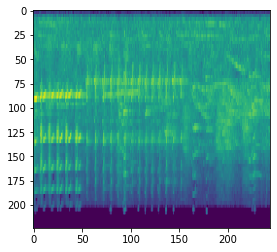

In [24]:
plt.imshow(interpolated[1,0])

In [4]:
df = pd.read_csv('data/ESC-50-master/meta/esc50.csv')

In [51]:
class MelFeaturizer(nn.Module):
    
    def __init__(self, sample_rate=16000, n_fft=1024, win_length=1024, hop_length=256, n_mels=64, center=True):
        super(MelFeaturizer, self).__init__()
        
        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            n_mels=n_mels,
            center=center
        )
        
    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()
        
        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            # We add `4` because in MelSpectrogram center==True
            length += 1 + 4
            
            return mel_spectrogram, length
        
        return mel_spectrogram

In [122]:
class LinearFeaturizer(nn.Module):
    def __init__(self, spectogram_featurizer, nan_to_num_value:float=-1) -> None:
        super().__init__()
        self.spectogram_featurizer = spectogram_featurizer
        self.nan_to_num_value = nan_to_num_value

    def forward(self, wav: torch.Tensor) -> torch.Tensor:
        spectogram = self.spectogram_featurizer(wav)
        if len(spectogram.shape) == 3:
            spectogram = spectogram.mean(0)

        mean = torch.mean(spectogram, dim=0)
        diffs = spectogram - mean
        var = torch.mean(torch.pow(diffs, 2.0), dim=0)
        std = torch.pow(var, 0.5)
        zscores = diffs / std
        skews = torch.mean(torch.pow(zscores, 3.0),  dim=0)
        kurtoses = torch.mean(torch.pow(zscores, 4.0),  dim=0) - 3.0 
        
        q25 = spectogram.quantile(0.25, dim=0)
        q50 = spectogram.quantile(0.5, dim=0)
        q75 = spectogram.quantile(0.75, dim=0)
        maxes = spectogram.quantile(1, dim=0)

        features = torch.stack([mean, std, skews, kurtoses, q25, q50, q75, maxes])
        features = features.nan_to_num(self.nan_to_num_value)

        return features.view(-1)



In [107]:
dataset = SimpleDataset(df, AUDIO_PATH)
spectogram_featurizer = MelFeaturizer()
linear_featurizer = LinearFeaturizer(spectogram_featurizer)

In [108]:
wav, label = dataset[1000]

In [113]:
mel_spectrogram = spectogram_featurizer(wav)

In [60]:
mel_spectrogram = mel_spectrogram.squeeze()

In [77]:
mean = torch.mean(mel_spectrogram, dim=0)
diffs = mel_spectrogram - mean
var = torch.mean(torch.pow(diffs, 2.0), dim=0)
std = torch.pow(var, 0.5)
zscores = diffs / std
skews = torch.mean(torch.pow(zscores, 3.0),  dim=0)
kurtoses = torch.mean(torch.pow(zscores, 4.0),  dim=0) - 3.0 

In [90]:
pd.concat(mean, skews)

/tmp/ipykernel_179487/539207410.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat(mean, skews)


TypeError: cannot concatenate object of type '<class 'torch.Tensor'>'; only Series and DataFrame objs are valid

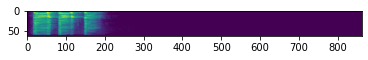

In [48]:
plt.imshow(mel_spectrogram[0])

In [68]:
torch.kurtosis(mel_spectrogram)

AttributeError: module 'torch' has no attribute 'kurtosis'

In [23]:
wav, sr = torchaudio.load(os.path.join(AUDIO_PATH, df.filename[100]))

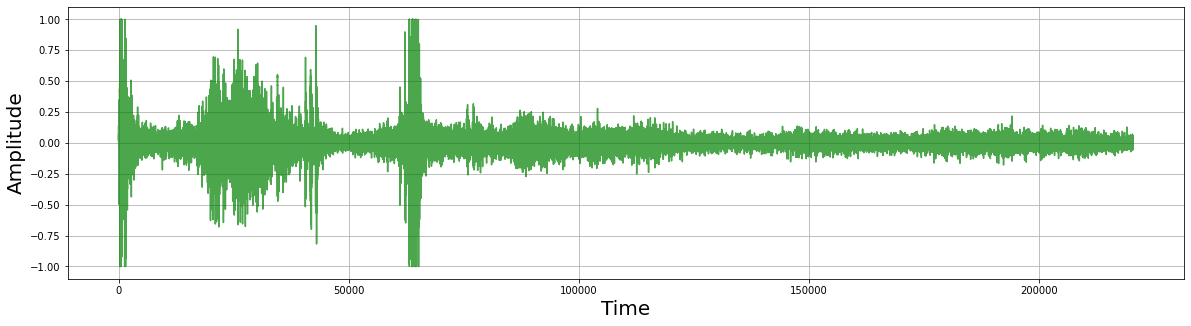

In [24]:
visualize_audio(wav, sr)